In [1]:
import numpy as np
import matplotlib.pyplot as plt

from CADMium import Kohnsham
from CADMium import Pssolver
from CADMium import Psgrid
from CADMium import Partition
from CADMium import Inverter

---
### Perform Isolated Li atom Calculation. 
Code should run as it is but for idential calculations increase to grid size to: [7,12,12]


In [2]:
#Distance of the nucley from grid center
a =  5.122/2

#Nuclear charges on centers AB
Za  = 3
Zb = 0

#Set polaization. 1 Unpolarized, 2 Polarized
pol = 1

Nmo = [[2]]
N   = [[3]]

optKS = {
        "interaction_type" : "dft",
        "SYM" : False,
        "FRACTIONAL" : True,
        }

#Grid Options
NP = 7 #Number of points per block
NM =  [4,4] #Number of blocks [angular, radial]
L = np.arccosh(15./a) #Maximum radial coordinate value
loc = np.array(range(-4,5)) #Non inclusive on upper bound

#Create and initialize grid object
grid = Psgrid(NP, NM, a, L, loc)
grid.initialize()

#Kohn Sham object
KS = Kohnsham(grid, Za, Zb, pol, Nmo, N, optKS)
KS.scf({})

#Store information of KS
# KS0 = KS.copy()

#Extract Isolated Fragment Density. 
Isolated_D = KS.n.copy()

 iter    Total Energy     HOMO Eigenvalue         Res       

----------------------------------------------------------- 

    1       -8.94918      -3.73526e-03       +1.00000e+00
    2       -7.86658      -8.18372e-02       +1.37621e-01
    3       -7.50246      -1.00191e-01       +4.85324e-02
    4       -7.38634      -1.05331e-01       +1.57216e-02
    5       -7.34959      -1.06403e-01       +4.99987e-03
    6       -7.33880      -1.06389e-01       +1.47022e-03
    7       -7.33517      -1.06223e-01       +4.94698e-04
    8       -7.33473      -1.05965e-01       +2.25394e-04
    9       -7.33481      -1.05797e-01       +1.25070e-04
   10       -7.33495      -1.05694e-01       +6.74942e-05
   11       -7.33506      -1.05634e-01       +3.56083e-05
   12       -7.33513      -1.05600e-01       +1.85342e-05
   13       -7.33517      -1.05581e-01       +9.57805e-06


---
### Perform PDFT Calculation. 
Currently the method used is "OrbitalInvert". 
But original code may have used "WuYang". 
Code should run as it is but for idential calculations increase to grid size to: [7,12,12]

In [3]:
a = 5.122/2
#Nuclear charge for fragments A and B
Za, Zb = 3,3
#Set polarization 1-Unpolarized, 2-Polarized
pol = 2
#Fragment a electrons [alpha, beta]
Nmo_a = [[2,1]] #Number of molecular orbitals to calculate
N_a   = [[2,1]]
#Ensemble mix
nu_a = 1
#Fragment b electrons
Nmo_b = [[2,1]]
N_b   = [[2,1]]
#Ensemble mix
nu_b = 1

#Molecular elctron configuration
Nmo_m = [[3,3]]
N_m   = [[3,3]]


#Initialize required objects. And make calculation in isolated fragments for initial guess. 

part = Partition(grid, Za, Zb, pol, Nmo_a, N_a, nu_a, Nmo_b, N_b, nu_b, { "kinetic_part_type" : 'inversion',
                                                                          "ab_sym"            : True,
                                                                          "ens_spin_sym"      : True,})

#Setup inverter object
mol_solver = Pssolver(grid, Nmo_m, N_m)
part.inverter = Inverter(grid, mol_solver, {"invert_type"     : "orbitalinvert",
                                            "tol_invert"      : 1e-10,
                                            "max_iter_invert" : 40,
                                            "disp"            : False,
                                            "ab_sym"          : True,
                                            "ens_spin_sym"    : True,})

part.optPartition.isolated = True
part.scf({"disp"  : True,
          "alpha" : [0.6],
          "e_tol" : 1e-12})


#Turn off iterative linear solver for each solver
part.KSa.solver[0][0].optSolver.iter_lin_solver = False
part.KSa.solver[0][1].optSolver.iter_lin_solver = False


part.optPartition.isolated   = False

part.scf({"disp"       : True,
          "alpha"      : [0.6],
          "max_iter"   : 50,
          "e_tol"      : 1e-10,
          "continuing" : True})

#Store full densities under the presence of vp.
Da_vp = part.nf[:,0].copy()
Db_vp = part.nf[:,1].copy()

                Total Energy ( a.u.)                               Inversion                

                __________________                ____________________________________     

Iteration         A              B                  iters      optimality        res       

___________________________________________________________________________________________ 

    1           -8.62301     -8.62301       1.000e+00 
    2           -7.59515     -7.59515       1.530e-01 
    3           -7.38724     -7.38724       5.758e-02 
    4           -7.34928     -7.34928       2.753e-02 
    5           -7.34331     -7.34331       1.291e-02 
    6           -7.34300     -7.34300       6.027e-03 
    7           -7.34348     -7.34348       2.683e-03 
    8           -7.34364     -7.34364       1.377e-03 
    9           -7.34379     -7.34379       6.411e-04 
   10           -7.34386     -7.34386       2.991e-04 
   11           -7.34388     -7.34388       1.403e-04 
   12           -7.34

---
### Perform Isolated Li Calculation under the presence of Vp. 
You are required to use the Kohn Sham calculation used in the original isolated fragment calculation. 
Code should run as it is but for idential calculations increase to grid size to: [7,12,12]

In [4]:
#Store vp from pdft calculation. 
vp = part.V.vp.copy()
vp = vp[:,0] + vp[:,1] 


#Setting continue : True is imoprtant otherwise veff gets scratched. 
KS.solver[0][0].veff += vp
KS.solver[0][0].calc_orbitals()
KS.solver[0][0].calc_density()
KS.solver[0][0].calc_energy()

#Save density under the presence of vp
vp_D = KS.n.copy()

---
### Generate Figure 9. Parititon Potential. 

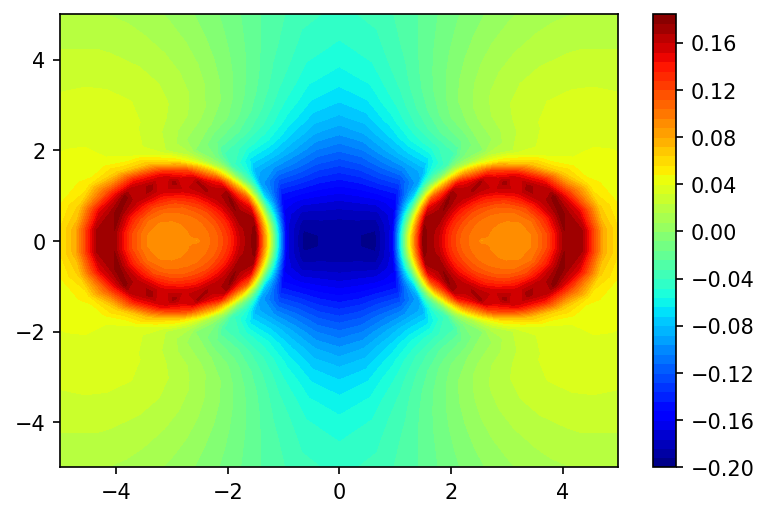

In [5]:
full, x,y = grid.plotter(part.V.vp[:,0] + part.V.vp[:,1])
fig = plt.figure(dpi=150)
plt.contourf(x,y,full, levels=50, cmap="jet")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.colorbar()
# plt.show()

---
### Generate Figure 9. Difference between Fragment Density and Isolated Atomic Density. 

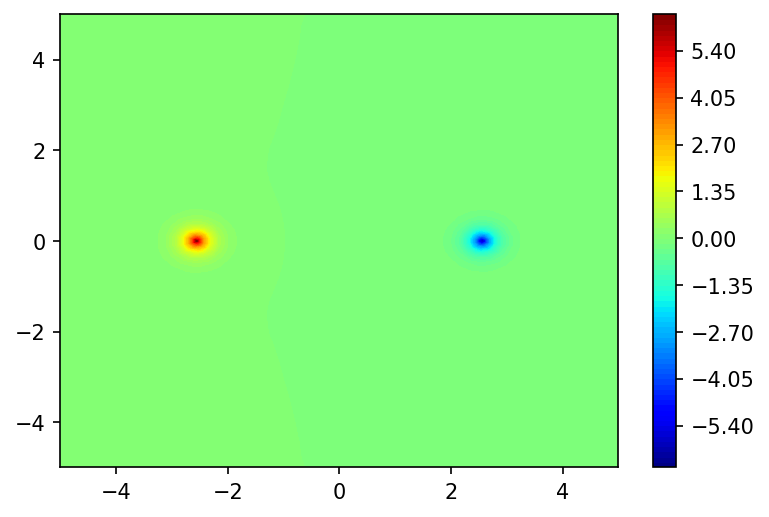

In [6]:
D_grid, x, y = grid.plotter(Isolated_D)
D_vp_grid, _, _ = grid.plotter(Da_vp)

fig = plt.figure(dpi=150)
plt.contourf(x,y, D_grid - D_vp_grid, levels=100, cmap="jet")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.colorbar()
# plt.show()

---
### Generate Figure 11. Components of the Partition Potential

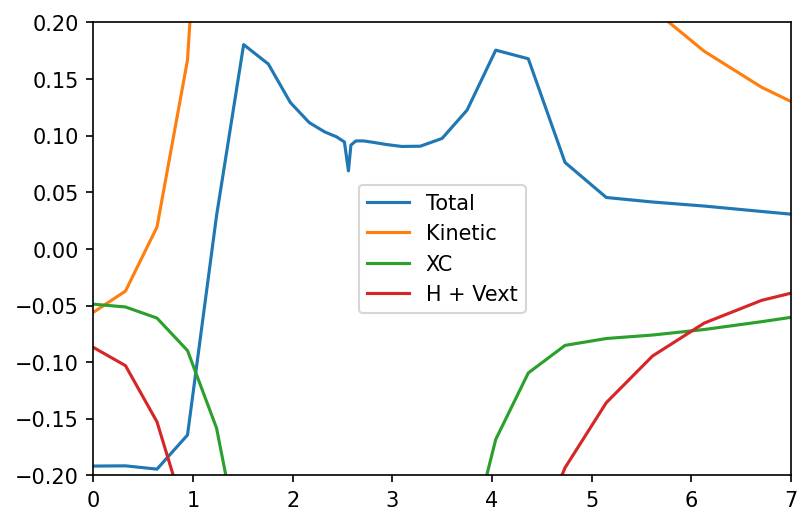

In [7]:
x_axis, vp = grid.axis_plot(part.V.vp[:,0] + part.V.vp[:,1])
x_axis, vp_kin = grid.axis_plot(part.V.vp_kin[:,0] + part.V.vp_kin[:,1])
x_axis, vp_xc = grid.axis_plot(part.V.vp_x[:,0] + part.V.vp_x[:,1] + part.V.vp_c[:,0] + part.V.vp_c[:,1])
x_axis, vp_hext = grid.axis_plot( part.V.vp_h[:,0] + part.V.vp_h[:,1] + part.V.vp_pot[:,0] + part.V.vp_pot[:,1])

fig = plt.figure(dpi=150)
plt.plot(x_axis, vp, label='Total')
plt.plot(x_axis, vp_kin, label='Kinetic')
plt.plot(x_axis, vp_xc, label='XC')
plt.plot(x_axis, vp_hext, label="H + Vext")

plt.xlim(0,7)
plt.ylim(-0.2, 0.2)

plt.legend()

---
### Generate Table 9. Energies and Components of Ep, in atomic Units

In [8]:
values = {}
for i in part.E.__dict__:
    if i.startswith("__") is False:
        values.update({i : getattr(part.E, i)})
values

{'Ea': -7.337997844051382,
 'Eb': -7.337997844051382,
 'Ef': -14.675995688102764,
 'Tsf': 14.478662971320972,
 'Eksf': array([[-3.87409418, -3.62211294]]),
 'Enucf': -33.851643819321716,
 'Exf': -3.0380872328509314,
 'Ecf': -0.30094318931435543,
 'Ehf': 8.036015582063266,
 'Vhxcf': 11.682716078989634,
 'Ep': -1.807111996982694,
 'Ep_pot': -3.6785643587624692,
 'Ep_kin': 0.0048665339310645095,
 'Ep_hxc': 1.8665858278487106,
 'Et': -16.483107685085457,
 'Vnn': 1.757126122608356,
 'E': -14.7259815624771,
 'evals_a': array([], dtype=float64),
 'evals_b': array([], dtype=float64),
 'Ep_h': 1.8866761032731887,
 'Ep_x': 0.007109573528655044,
 'Ep_c': -0.0271998489531331}

In [9]:
x_axis,vp = grid.axis_plot(part.V.vp[:,0] + part.V.vp[:,1])